<a href="https://colab.research.google.com/github/nilaynishant/AIMLTutorial/blob/main/TorchGeobasics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torchgeo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.7/670.7 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [4]:
import os
import tempfile
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchgeo.datasets import NAIP,RasterDataset, ChesapeakeDE, stack_samples
from torchgeo.samplers import RandomGeoSampler, BatchGeoSampler, GridGeoSampler
from torchgeo.datasets.utils import download_url

In [5]:
BATCH_SIZE = 10
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR=0.001

In [6]:
naip_root = os.path.join(tempfile.gettempdir(), "naip")
naip_url = (
    "https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/"
)
tiles = [
    "m_3807511_ne_18_060_20181104.tif",
    "m_3807511_se_18_060_20181104.tif",
    "m_3807512_nw_18_060_20180815.tif",
    "m_3807512_sw_18_060_20180815.tif",
]
for tile in tiles:
    download_url(naip_url + tile, naip_root)

naip = NAIP(naip_root)

100%|██████████| 513332284/513332284 [01:03<00:00, 8133373.96it/s]


100%|██████████| 521985441/521985441 [01:00<00:00, 8627240.51it/s]


100%|██████████| 489865657/489865657 [00:50<00:00, 9679036.64it/s] 


100%|██████████| 484476647/484476647 [00:56<00:00, 8603185.79it/s]


In [7]:
chesapeake_root = os.path.join(tempfile.gettempdir(), "chesapeake")
os.makedirs(chesapeake_root, exist_ok=True)
chesapeake = ChesapeakeDE(chesapeake_root, crs=naip.crs, res=naip.res, download=True)

100%|██████████| 287350495/287350495 [00:35<00:00, 8081288.64it/s]


In [8]:
dataset = naip&chesapeake
sampler = RandomGeoSampler(dataset, size=256, length=500)
image_tensors = DataLoader(dataset, sampler=sampler, batch_size=BATCH_SIZE, collate_fn=stack_samples)

In [7]:
# Define U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3

In [9]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=4, out_channels=13, init_features=32)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip


In [ ]:
import torch.optim as optim

# Instantiate the model, loss function, and optimizer
# model = UNet(in_channels=4, out_channels=13)  # Adjust in_channels and out_channels based on your task
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.to(DEVICE)

for epoch in range(EPOCHS):

    for data in image_tensors:
        #forward pass
        inputs=data['image'].to(DEVICE)
        targets=data['mask'][:,0,...].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)

        #backward pass
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {loss.item()}')


In [52]:
random_image=next(iter(image_tensors))
image = random_image['image'].to(DEVICE)
mask = random_image['mask'].to(DEVICE)
output_predicted = model(image)


In [53]:
masked = torch.argmax(output_predicted, dim=1)
masked = masked.cpu().squeeze(0)
image = image.cpu().squeeze(0)
mask = mask.cpu().squeeze(0)


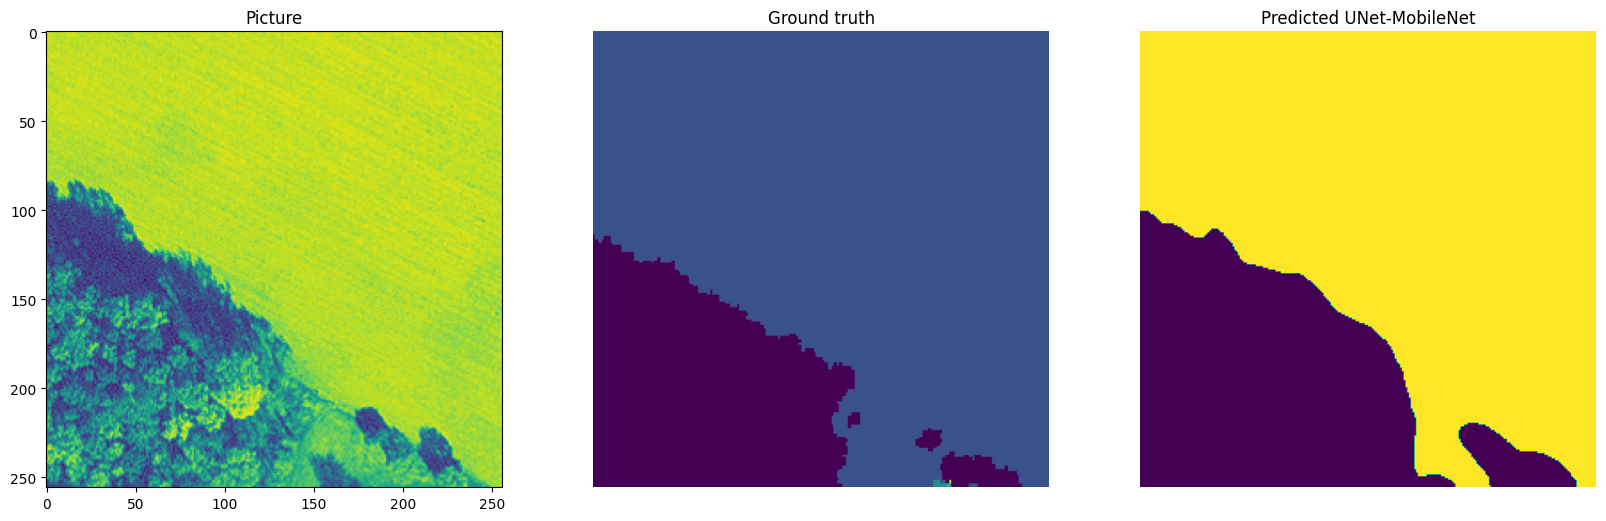

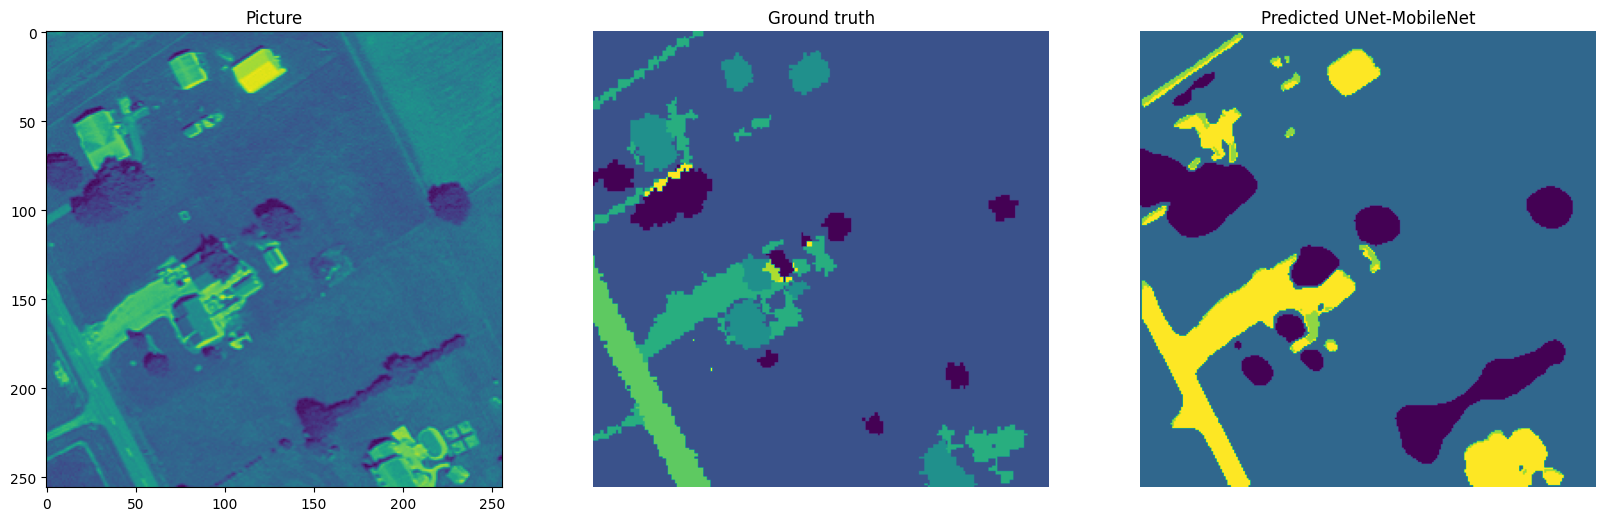

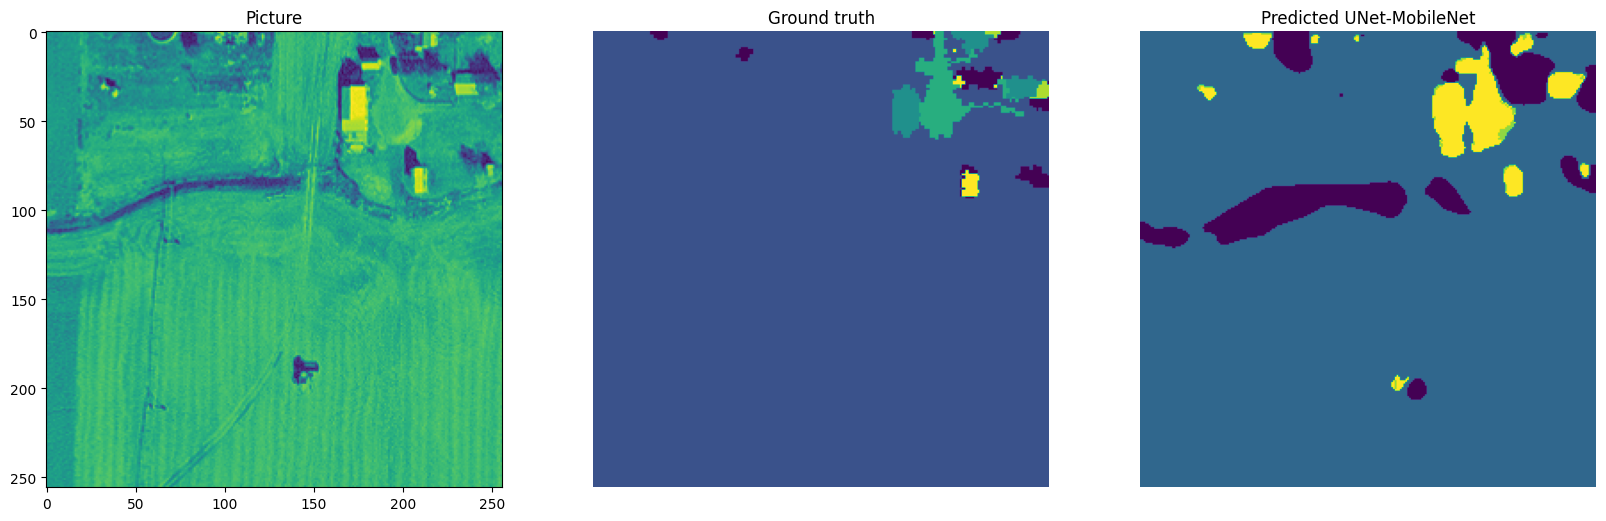

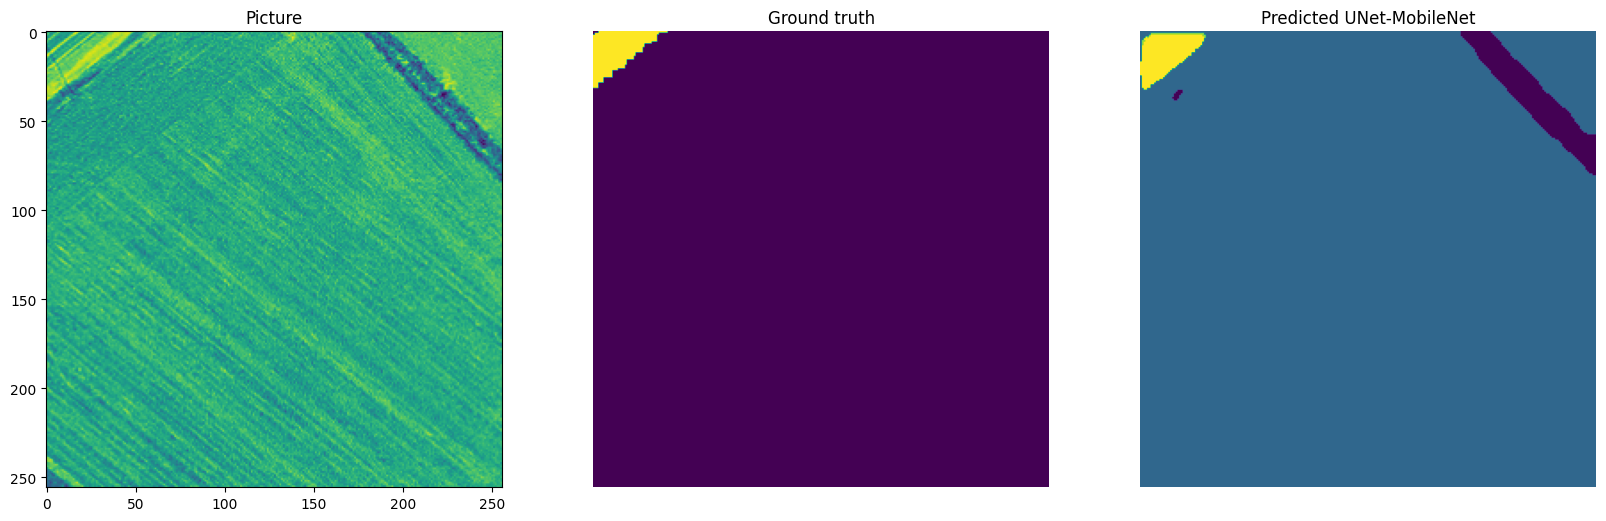

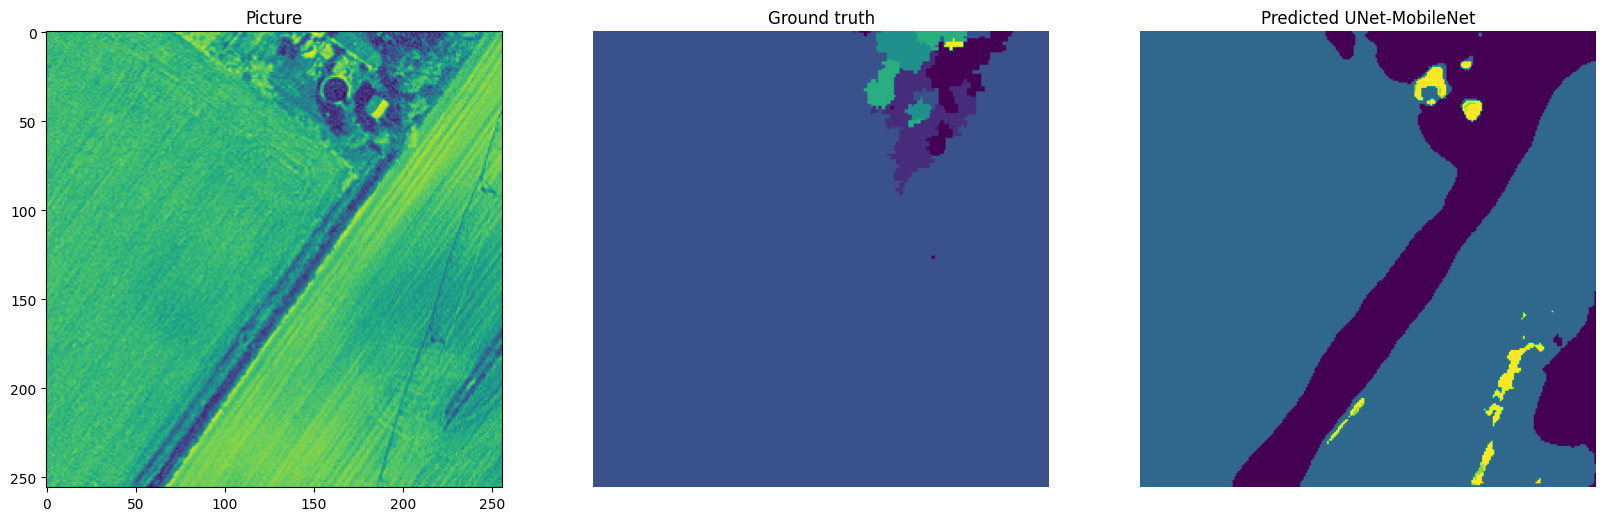

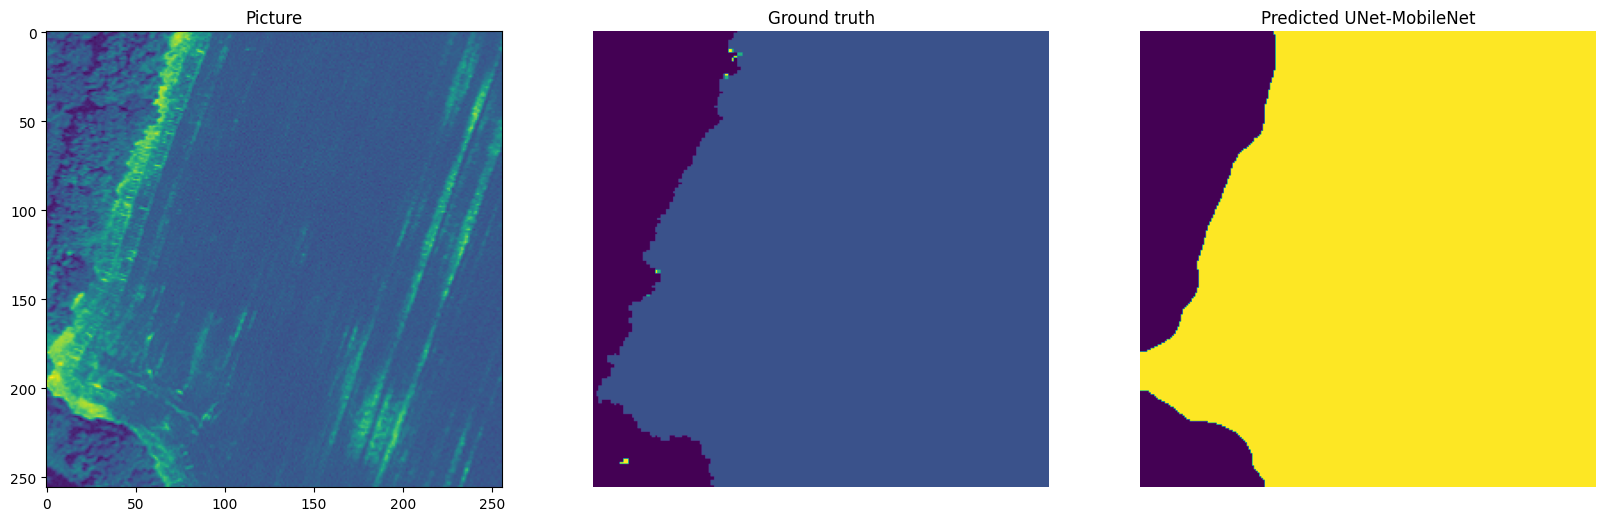

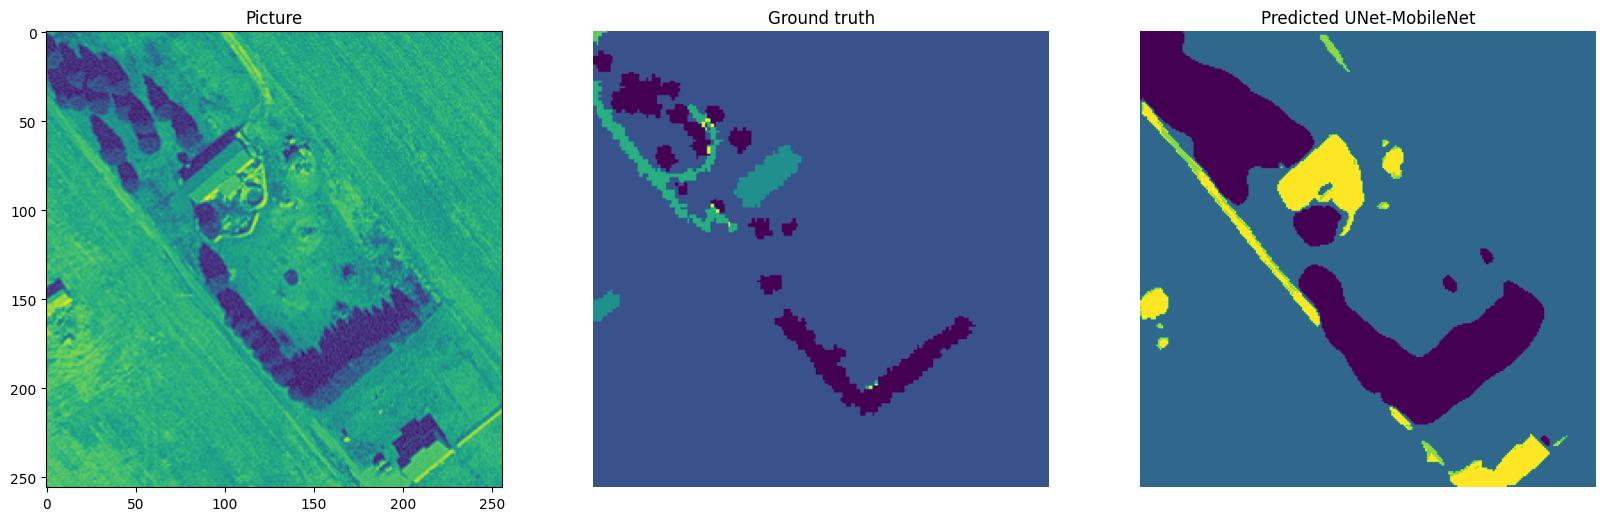

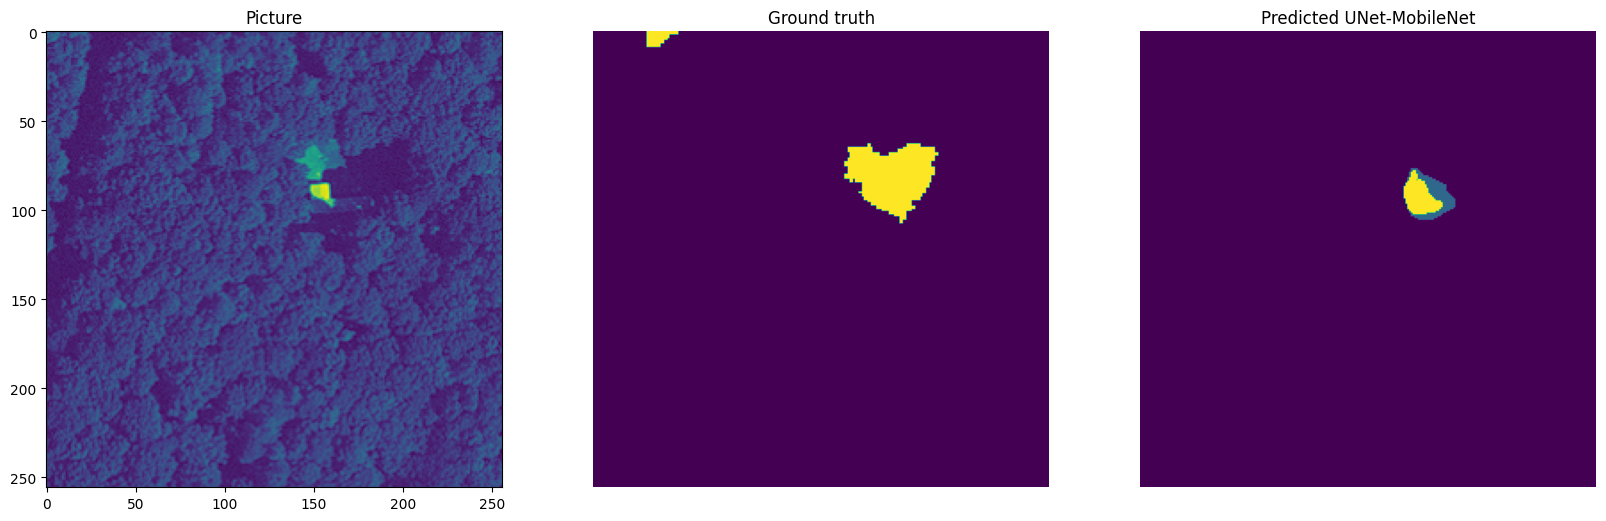

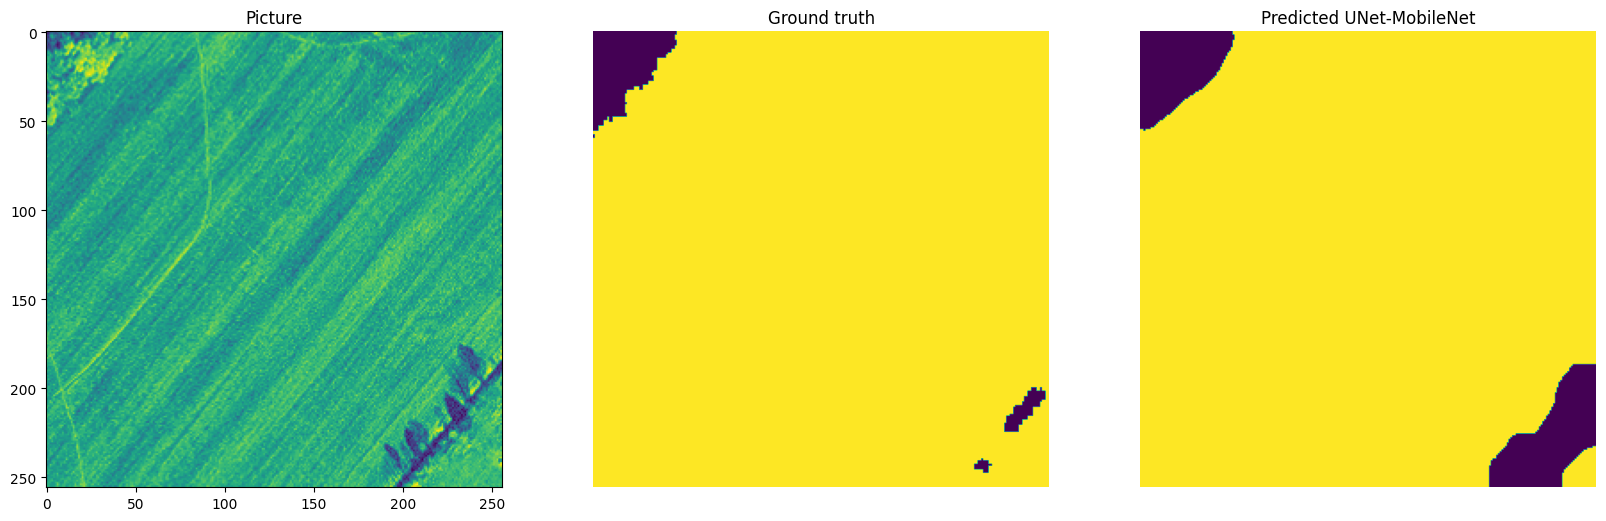

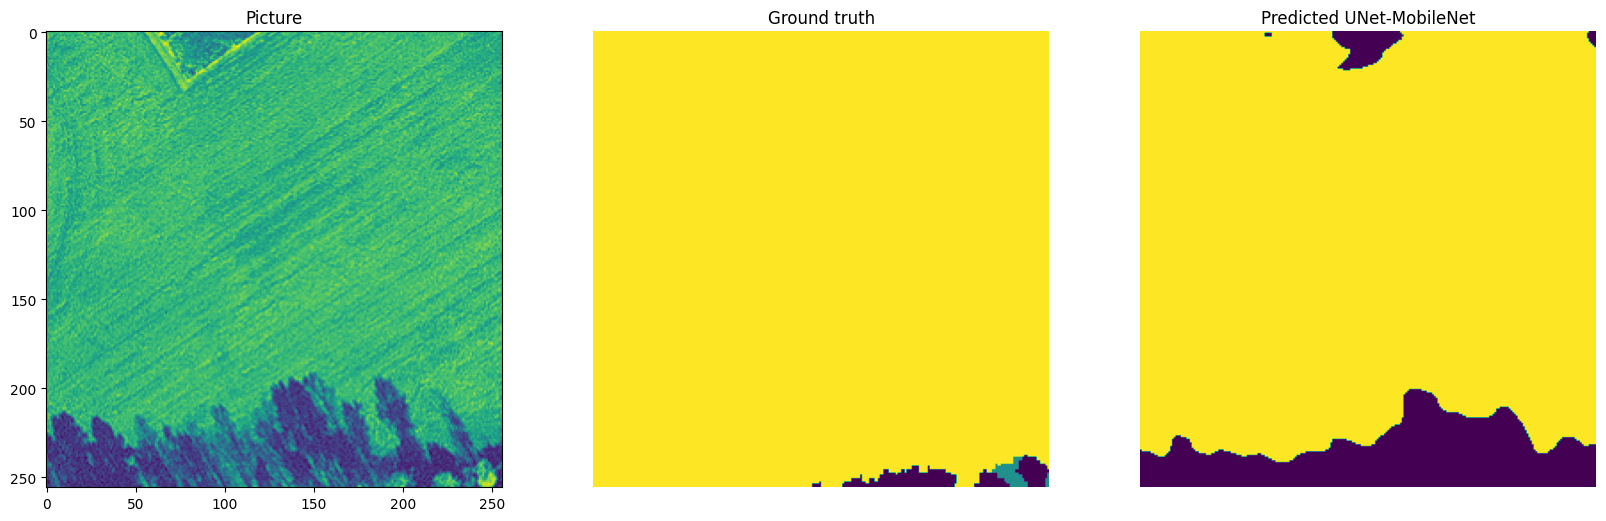

In [56]:
import matplotlib.pyplot as plt

for i in range(10):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image[i,0,...])
  ax1.set_title('Picture');

  ax2.imshow(mask[i,0,...])
  ax2.set_title('Ground truth')
  ax2.set_axis_off()

  ax3.imshow(masked[i,...])
  ax3.set_title('Predicted UNet-MobileNet')
  ax3.set_axis_off()